# Lorenz-96 experiment
## From the paper "Distribution-free inference with hierarchical data"

The script reproduces the experiment in Section 4.


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pdb, random
import argparse, os
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import warnings
import torch
from torch import nn
import torch.optim as optim

## Note on the data
This script loads data generated previously. To generate new data, run the script `generate_L96_data.ipynb`. The below text describes the data setup.

##### Step 1: Randomly draw $k$ initial conditions from normal distributons and run the simulation model to time $T_0$.

##### Step 2: For each group $k$, we perturb the state at $T_0$ by adding a slight amount of noise $\eta_n$ for $n = 1,\ldots,N_k$.
$$ u_{k, n}(T_0) = u_{k}(T_0) + r \eta_{k,n},$$
where $ \eta_n \sim \mathcal{N}(0, 1)$ and $r$ is a scalar.

We then use $u_{k,n}$ as the initial conditions and run the L96 solver with the perturbed initial condtions for $K$ groups and $N_k$ perturbations for each group.

The values of these quantities in the pre-generated data are in the code block below.

In [2]:
r_eta_perturb = 0.5
time_step = 0.05
# spin up time T_0 for dynamical system
T_0 = 20
# run time T_max after perturbing state at time T_0
T_max = 5
# set time T at which we have response Y;
#T = 0.5 # corresponds to Z_index = 10
T = 0.05 # corresponds to Z_index = 1
T = round(T/time_step)*time_step # ensures Z_index an integer when T = Z_index * time_step
M = 10
K, N_k = 800, 50

seeds_base = 0
train_data_folder = [f'train', seeds_base]
seeds_base = seeds_base + K * N_k
calibration_data_folder = [f'calibration', seeds_base]
seeds_base = seeds_base + K * N_k
test_data_folder = [f'test', seeds_base]

#### Load saved data

In [3]:
train_tuple = torch.load(f'{train_data_folder[0]}.pth')
calibration_tuple = torch.load(f'{calibration_data_folder[0]}.pth')
test_tuple = torch.load(f'{test_data_folder[0]}.pth')

### The saved data is a tuple that contains two parts:
##### E.g., for the training data:
The first part: the dynamic data generated from perturbed initial conditions.
- dim 0: number of samples $K= 800$
- dim 1: number of perturbations $N_k = 50$
- dim 2: number of time samples $T_{max}/dt=100$  where $dt$ = time_step
- dim 3: number of channels $M = 10$  

The 2nd part: unperturbed initial conditions after T_0 burn out, this is our X used for training.  
- dim 0: number of samples $K = 800$  
- dim 1: number of pertrubtations $N_k = 50$   
- dim 2: number of channels $M = 10$

In [4]:
## X_train: unperturbed initial conditions of shape K x N_k x M.
X_train_np = train_tuple[1]
X_calibration_np = calibration_tuple[1]
X_test_np = test_tuple[1]

## train_data: data generated from perturbed initial conditions of shape K x N_k x T_max x M.
train_data = train_tuple[0]
calibration_data = calibration_tuple[0]
test_data = test_tuple[0]

train_data = train_data.reshape(-1, train_data.shape[-2], train_data.shape[-1])
calibration_data = calibration_data.reshape(-1, calibration_data.shape[-2], calibration_data.shape[-1])
test_data = test_data.reshape(-1, test_data.shape[-2], test_data.shape[-1])

### After reshaping the data:

- X_train is $40000 \times 10 = KN_k \times M$
- train_data is $40000 \times 100 \times 10 = KN_k \times T_{max}/dt \times M$ where $dt = $ time_step

## If you want to rerun training, etc but not reload data, start here.

In [5]:
random.seed(1)
np.random.seed(1)

In [6]:
## use state at u(T) as X and u(T + dt) as Y

# T = Z_index * time_step

Z_index = round(T/time_step)
Y_index = 0

X_train = torch.from_numpy(X_train_np).float()
X_train_reshape = X_train.reshape(-1, X_train.shape[-1])
Z_train = torch.from_numpy(train_data[:, Z_index])
Z_train = Z_train.float()
Y_train = Z_train[:, Y_index].reshape(-1, 1)

In [7]:
Y_tr = train_tuple[0][:,:,Z_index,Y_index]
Y_train_sd = np.std(Y_tr,axis=1)
Y_train_sd = torch.from_numpy(Y_train_sd).float()
Y_train_sd_reshape = np.repeat(Y_train_sd,50).reshape(40000,1)

In [8]:
X_calibration = calibration_tuple[1][:,0,:]
X_calibration = torch.from_numpy(X_calibration).float()
Y_calibration = calibration_tuple[0][:,:,Z_index,Y_index]
X_test = test_tuple[1][:,0,:]
X_test = torch.from_numpy(X_test).float()
Y_test = test_tuple[0][:,:,Z_index,Y_index]

### Initialize the NN

In [9]:
from torch import nn

class Net(nn.Module):
    def __init__(self, input_dim=M, hidden_dim=20, output_dim=1):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate the model
model = Net()

### Start the training with SGD optimizer

#### Fit $\hat{\mu}$

In [10]:
# Instantiate the model
model = Net()

# Set the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=9e-4)

# Set the batch size
batch_size = 5000
n_epochs = 1000
n_samples = X_train_reshape.shape[0]

# Start training
for epoch in tqdm(range(n_epochs)):
    permutation = torch.randperm(n_samples)

    for i in range(0, n_samples, batch_size):
        optimizer.zero_grad()

        # Create minibatch
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_reshape[indices], Y_train[indices]

        # Forward pass
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        model.train()

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 194.57it/s]


#### Fit $\hat{\sigma}$

In [11]:
# Instantiate the model
model_sd = Net()

# Set the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model_sd.parameters(), lr=9e-4)

# Set the batch size
batch_size = 5000
n_epochs = 1000
n_samples = X_train_reshape.shape[0]

# Start training
for epoch in tqdm(range(n_epochs)):
    permutation = torch.randperm(n_samples)

    for i in range(0, n_samples, batch_size):
        optimizer.zero_grad()

        # Create minibatch
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_reshape[indices], Y_train_sd_reshape[indices]

        # Forward pass
        outputs = model_sd(batch_x)
        loss = loss_fn(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        model_sd.train()

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 213.69it/s]


## Functions for running HCP and HCP$^2$

In [12]:
#quantile function
def quantile(probs,values,level):
  values_rank = np.argsort(values)
  rank_alpha = np.min(np.where((np.cumsum(probs[values_rank]) >= 1-level) == True))
  q = values[values_rank[rank_alpha]]
  return q

#HCP for data with repeated observations
def HCP_repeated_obs(X,Y_tilde,group_sizes,alpha,score):
  K = np.shape(X)[0]

  values = []
  prob = []

  for i in range(K):
    values = values+(score[i,:]).tolist()
    prob = prob+[1/((K+1)*group_sizes[i])]*group_sizes[i]

  values = np.array(values+[np.inf])
  prob = np.array(prob+[1/(K+1)])

  q_HCP = quantile(prob,values,alpha)

  return q_HCP

#HCP2 for data with repeated observations
def HCP2_repeated_obs(X,Y_tilde,group_sizes,alpha,score):
  K = np.shape(X)[0]

  K_2 = np.sum(np.array(group_sizes[0:K]) >= 2)
  values = []
  prob = []

  for i in range(K):
    if group_sizes[i] >= 2:

      N_K = group_sizes[i]
      score_sorted = np.sort(score[i,:])

      for j in range(N_K):
        values = values+[score_sorted[j]]
        prob = prob + [(N_K - (j+1))/((K_2+1)*N_K*(N_K-1)/2)]


  values = np.array(values+[np.inf])
  prob = np.array(prob+[1/(K_2+1)])

  q_HCP2 = quantile(prob,values,alpha**2)

  return q_HCP2

## Run HCP \& HCP$^2$

In [13]:
#get estimates and compute scores
model.eval()
muhat_calibration = model(X_calibration).reshape(800)
muhat_test = model(X_test).reshape(800)
muhat_calibration = muhat_calibration.detach().numpy()
muhat_test = muhat_test.detach().numpy()

model_sd.eval()
sdhat_calibration = torch.abs(model_sd(X_calibration)).reshape(800)
sdhat_test = torch.abs(model_sd(X_test)).reshape(800)
sdhat_calibration = sdhat_calibration.detach().numpy()
sdhat_test = sdhat_test.detach().numpy()

score_calibration = np.divide(np.abs(Y_calibration - np.outer(muhat_calibration,np.ones(N_k))),np.outer(sdhat_calibration,np.ones(N_k)))

In [14]:
#run HCP and HCP2
alpha=0.2
group_sizes = [N_k]*K

q_HCP = HCP_repeated_obs(X_calibration,Y_calibration,group_sizes,alpha,score_calibration)
q_HCP2 = HCP2_repeated_obs(X_calibration,Y_calibration,group_sizes,alpha,score_calibration)
print(q_HCP,q_HCP2)

1.5376114343523934 1.6514615943450812


In [15]:
#compute conditional coverage rates and widths of prediction intervals
coverage_HCP = np.multiply(np.outer(muhat_test - q_HCP*sdhat_test,np.ones(50)) < Y_test , Y_test < np.outer(muhat_test + q_HCP*sdhat_test,np.ones(50)))
coverage_HCP2 = np.multiply(np.outer(muhat_test - q_HCP2*sdhat_test,np.ones(50)) < Y_test , Y_test < np.outer(muhat_test + q_HCP2*sdhat_test,np.ones(50)))

conditional_coverage_HCP = np.mean(coverage_HCP,axis=1)
conditional_coverage_HCP2 = np.mean(coverage_HCP2,axis=1)
width_HCP = 2*q_HCP*sdhat_test
width_HCP2 = 2*q_HCP2*sdhat_test

In [16]:
# Compute marginal/squared coverage rates
miscoverage_count_HCP_1 = N_k-conditional_coverage_HCP*N_k
squared_miscoverage_HCP_1 = np.mean(np.multiply(miscoverage_count_HCP_1,miscoverage_count_HCP_1)/(N_k*(N_k-1)))
squared_miscoverage_HCP_1_se = np.std(np.multiply(miscoverage_count_HCP_1,miscoverage_count_HCP_1)/(N_k*(N_k-1)))/np.sqrt(K)
miscoverage_count_HCP2_1 = N_k-conditional_coverage_HCP2*N_k
squared_miscoverage_HCP2_1 = np.mean(np.multiply(miscoverage_count_HCP2_1,miscoverage_count_HCP2_1)/(N_k*(N_k-1)))
squared_miscoverage_HCP2_1_se = np.std(np.multiply(miscoverage_count_HCP2_1,miscoverage_count_HCP2_1)/(N_k*(N_k-1)))/np.sqrt(K)

### Table of coverage rates \& widths

In [17]:
#row : HCP / HCP2
#column : marginal miscoverage rate / std / squared miscoverage rate / std / width / std
table = np.zeros((2,6))
table[0,:] = [1-np.mean(conditional_coverage_HCP),np.std(conditional_coverage_HCP)/np.sqrt(K),squared_miscoverage_HCP_1,squared_miscoverage_HCP_1_se,np.mean(width_HCP),np.std(width_HCP)/np.sqrt(K)]
table[1,:] = [1-np.mean(conditional_coverage_HCP2),np.std(conditional_coverage_HCP2)/np.sqrt(K),squared_miscoverage_HCP2_1,squared_miscoverage_HCP2_1_se,np.mean(width_HCP2),np.std(width_HCP2)/np.sqrt(K)]
np.set_printoptions(suppress=True)
print(np.round(table,4))

[[0.201  0.0046 0.0587 0.0037 1.5347 0.004 ]
 [0.1698 0.0045 0.0457 0.0033 1.6483 0.0043]]


### Histograms

/tmp/ipykernel_11099/3328022045.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


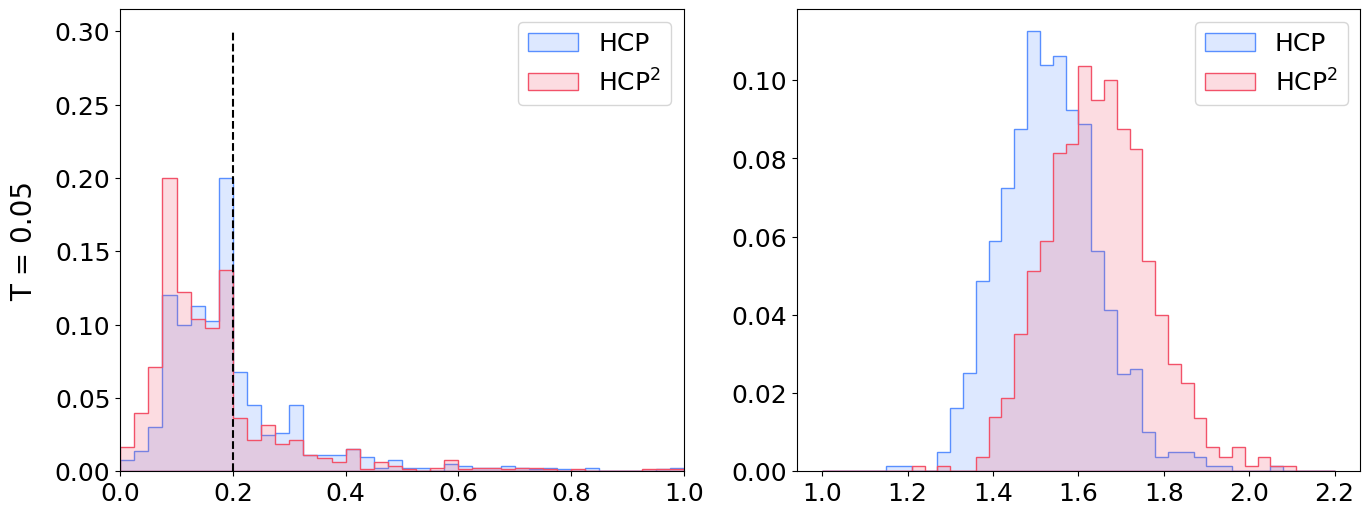

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
m=800
grid_coverage = np.linspace(0,1,41)
ax1.hist(1-conditional_coverage_HCP,grid_coverage,histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(m)/m, label = "HCP")
ax1.hist(1-conditional_coverage_HCP2,grid_coverage,histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(m)/m, label = "HCP$^2$")
ax1.set_xlim([0,1])
#ax1.set_xlabel("conditional miscoverage rates",fontsize=20, labelpad=10)
ax1.vlines(0.2,ymin=0,ymax=0.3,linestyles="dashed",color="black")
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)
ax1.set_ylabel("T = 0.05", fontsize=20,labelpad=12)
ax1.legend(loc='upper right',fontsize=18)

grid_width = np.linspace(1,2.2,41)
ax2.hist(width_HCP,grid_width,histtype='stepfilled',color=(0.35,0.56,1,0.2),edgecolor = (0.35,0.56,1,1),weights=np.ones(m)/m, label = "HCP")
ax2.hist(width_HCP2,grid_width,histtype='stepfilled',color=(0.95,0.32,0.41,0.2),edgecolor = (0.95,0.32,0.41,1),weights=np.ones(m)/m, label = "HCP$^2$")
#ax2.set_xlabel("prediction interval widths",fontsize=20, labelpad=10)
#ax2.vlines(0.2,ymin=0,ymax=0.35,linestyles="dashed",color="black")
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax2.legend(loc='upper right',fontsize=18)


fig.show()
#fig.savefig(('Z_index_1_10.png'),dpi=400,bbox_inches='tight')